In [1]:
import pickle
from phystables import BasicTable, SimpleTable, make_noisy
from phystables.constants import *
import define_tables
from define_tables import WallData, GoalData, BallData, TableData
import pygame as pg
import argparse
import numpy as np
import pandas as pd
from scipy.stats import entropy


DEF_NOISE = {
"kapv": KAPV_DEF, # VonMises precision on initial velocity angle estimation
"kapb": KAPB_DEF, # VonMises precision on the bounce angle estimation
"kapm": KAPM_DEF, # VonMises precision on the motion jitter
"perr": PERR_DEF  # Gaussian error on initial position estimation
}

def _ballhit(balllist):
    blcol = list(map(lambda b: b.col, balllist))
    print("Observed ball collisions: ", blcol)

def _goalhit(ball, goal):
    gtype = get_const(goal.ret)
    print("Ball", ball.col, "hit goal", gtype)

        
def getTable(tables_file, table_id, purpleBall, goldBall, noisy, callback=False, printTable=False):
    '''
    tables_file: File name with tables
    table_id: Table from table_files
    trial_id: Determines which simulation to run 
    noisy: T/F
    callback: T/F
    '''
    with open(tables_file, 'rb') as input:
        tablesData = pickle.load(input)
    tableData = tablesData[table_id]
    

            
    
    table = BasicTable(dims=tableData.dims)
    if printTable:
        print('\nWall Data:')
    for i, wall in enumerate(tableData.walls):
        table.add_wall(upperleft=wall.upperleft, lowerright=wall.lowerright)
        if printTable:
            print(str(i)+ ':', 'wall.upperleft', wall.upperleft)
            print(str(i)+ ':', 'wall.lowerright', wall.lowerright)

    if printTable:
            print('\nGoal Data:')
    for i, goal in enumerate(tableData.goals):
        table.add_goal(upperleft=goal.upperleft, lowerright=goal.lowerright, onreturn=goal.onreturn, color=goal.color)
        if printTable:
            print(str(i)+ ':', 'goal.upperleft', goal.upperleft)
            print(str(i)+ ':', 'goal.lowerright', goal.lowerright)
            print(str(i)+ ':', 'goal.onreturn', goal.onreturn)
            print(str(i)+ ':', 'goal.color', goal.color)
        
    balls = tableData.balls
    if purpleBall and goldBall:
        ball_id=2
    elif purpleBall:
        ball_id=0
    elif goldBall:
        ball_id=1
    if ball_id == 0 or ball_id==1:
        table.add_ball(initpos=balls[ball_id].initpos, initvel=balls[ball_id].initvel, color=balls[ball_id].color)
        if printTable:
            print('\nBall Data:')
            print(str(ball_id)+ ':'+ ':', 'balls.color', balls[ball_id].color)
            print(str(ball_id)+ ':', 'balls.initpos',    balls[ball_id].initpos)
            print(str(ball_id)+ ':', 'balls.initvel',    balls[ball_id].initvel)
    else:
        table.add_ball(initpos=balls[0].initpos, initvel=balls[0].initvel, color=balls[0].color)
        table.add_ball(initpos=balls[1].initpos, initvel=balls[1].initvel, color=balls[1].color)
        if printTable:
            print('\nBall Data:')
            print(str(0)+ ':', 'balls.color',   balls[0].color)
            print(str(0)+ ':', 'balls.initpos', balls[0].initpos)
            print(str(0)+ ':', 'balls.initvel', balls[0].initvel)
            print(str(1)+ ':', 'balls.color',   balls[1].color)
            print(str(1)+ ':', 'balls.initpos', balls[1].initpos)
            print(str(1)+ ':', 'balls.initvel', balls[1].initvel)
        
    if noisy:
        table = make_noisy(table, **DEF_NOISE)
        
    if callback:
        table.on_ballhit = _ballhit
        table.on_goalhit = _goalhit
    
    return table

def run_to_end(trial, max_time=10.):
    while True:
        r = trial.step(t=max_time, maxtime=max_time)
        if r is not None:
            if isinstance(r, list):
                r = r[0]
            return [r, trial.tm]
    
def run_simulations(tables_file, table_id, purpleBall, goldBall, noisy, num_simulations, max_time, callback=False):    
    simulations = []
    for i in range(num_simulations):
        table = getTable(tables_file, table_id, purpleBall, goldBall, noisy, callback)
        ret, simTime = run_to_end(table, max_time)
        goalHit = get_const(ret)
        ballHit = None
        ballHit = None
        simulation = [table_id, purpleBall, goldBall, goalHit, ballHit, simTime, noisy]
        simulations.append(simulation)
    return simulations

pygame 2.0.0 (SDL 2.0.12, python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Darwin (64bit) [/opt/anaconda3/envs/physenv/lib/python3.7/site-packages/pymunk/libchipmunk.dylib]


In [2]:
!python define_tables.py

pygame 2.0.0 (SDL 2.0.12, python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Darwin (64bit) [/opt/anaconda3/envs/physenv/lib/python3.7/site-packages/pymunk/libchipmunk.dylib]


# Run Simulations and Save to Lookup Table

In [5]:
columns = ['tableID', 'purpleBall', 'goldBall', 'goalHit', 'ballHit', 'simTime', 'noisy']
LookUpTable = pd.DataFrame(columns=columns)


for ix in range(4):
    simulations = run_simulations(tables_file='tables_metadata.pkl', 
                                  table_id=ix, 
                                  purpleBall=True,
                                  goldBall=False,
                                  noisy=True, 
                                  num_simulations=5000, 
                                  max_time=10)
    LookUpTable = LookUpTable.append(pd.DataFrame(data=simulations, columns=columns), ignore_index=True)  
    print('here: 5000')

    simulations = run_simulations(tables_file='tables_metadata.pkl', 
                                  table_id=ix, 
                                  purpleBall=False,
                                  goldBall=True,
                                  noisy=True, 
                                  num_simulations=5000, 
                                  max_time=10)
    LookUpTable = LookUpTable.append(pd.DataFrame(data=simulations, columns=columns), ignore_index=True)
    print('here: 10000')

    simulations = run_simulations(tables_file='tables_metadata.pkl', 
                                  table_id=ix, 
                                  purpleBall=True,
                                  goldBall=True,
                                  noisy=True, 
                                  num_simulations=5000, 
                                  max_time=10)
    LookUpTable = LookUpTable.append(pd.DataFrame(data=simulations, columns=columns), ignore_index=True)  
    print('here: 15000')

# Save LookUpTable to file
LookUpTable.to_pickle("LookUpTable.pkl")

# Display Table Up to x columns
pd.set_option("display.max_rows", 100, "display.max_columns", 7)
LookUpTable

here: 5000
here: 10000
here: 15000
here: 5000
here: 10000
here: 15000
here: 5000
here: 10000
here: 15000
here: 5000
here: 10000
here: 15000


,tableID,purpleBall,goldBall,goalHit,ballHit,simTime,noisy
0,0,True,False,REDGOAL,None,1.626,True
1,0,True,False,REDGOAL,None,1.558,True
2,0,True,False,REDGOAL,None,7.623,True
3,0,True,False,TIMEUP,None,10.001,True
4,0,True,False,GREENGOAL,None,2.991,True
...,...,...,...,...,...,...,...
59995,3,True,True,GREENGOAL,None,1.387,True
59996,3,True,True,GREENGOAL,None,1.338,True
59997,3,True,True,REDGOAL,None,1.417,True
59998,3,True,True,GREENGOAL,None,1.357,True


In [6]:
pd.set_option("display.max_rows", 1000, "display.max_columns", 7)
LookUpTable

,tableID,purpleBall,goldBall,goalHit,ballHit,simTime,noisy
0,0,True,False,REDGOAL,None,1.626,True
1,0,True,False,REDGOAL,None,1.558,True
2,0,True,False,REDGOAL,None,7.623,True
3,0,True,False,TIMEUP,None,10.001,True
4,0,True,False,GREENGOAL,None,2.991,True
...,...,...,...,...,...,...,...
59995,3,True,True,GREENGOAL,None,1.387,True
59996,3,True,True,GREENGOAL,None,1.338,True
59997,3,True,True,REDGOAL,None,1.417,True
59998,3,True,True,GREENGOAL,None,1.357,True


# Read File, Select Values, and Turn into List

In [7]:
# Read Table In
LookUpTable = pd.read_pickle("LookUpTable.pkl")

# # Group Table and Select Group by values
# simulation_groups = unpickledLookUpTable.groupby(['tableID', 'purpleBall'])
# group_simulations = simulation_groups.get_group(name=(0,True)) # return dataframe for just tableID=0 and purpleBall=True
# # turn into a list
# group_simulations.values.tolist()
LookUpTable

,tableID,purpleBall,goldBall,goalHit,ballHit,simTime,noisy
0,0,True,False,REDGOAL,None,1.626,True
1,0,True,False,REDGOAL,None,1.558,True
2,0,True,False,REDGOAL,None,7.623,True
3,0,True,False,TIMEUP,None,10.001,True
4,0,True,False,GREENGOAL,None,2.991,True
...,...,...,...,...,...,...,...
59995,3,True,True,GREENGOAL,None,1.387,True
59996,3,True,True,GREENGOAL,None,1.338,True
59997,3,True,True,REDGOAL,None,1.417,True
59998,3,True,True,GREENGOAL,None,1.357,True


In [5]:
################
# Small Oracle #
################

import random

def small_oracle(samples, num_sim_1, num_sim_2, iters=1000):
    '''
    samples:        Pre-run samples to draw from, list [Ball_1, Ball_2]
    num_sim_1:      Number of simulations for ball 1
    num_sim_2:      Number of simulations for ball 2
    samples:        Number of samples (each sample has num_sim_1 + 2 sims)
    Return tuple(# green wins, # red wins, avg total time)
    # green wins:   Number of samples where #G > #R + 0.5 * ties
    # red wins:     Number of samples where #G < #R + 0.5 * ties
    avg total time: Average total time for a sample
    '''
    g_wins = 0  # track green wins
    r_wins = 0  # track red wins
    total_time = 0  # total time

    for _ in range(iters):  # get samples
        # wins for a fixed sample
        sample_g_wins = 0
        sample_r_wins = 0
        sample_time = 0
        # simulations for ball 1
        for sim_1 in range(num_sim_1):
            table_id,_, _, outcome, _, time, _ = random.choice(samples[0])
            if outcome == 'GREENGOAL':
                sample_g_wins += 1
            if outcome == 'REDGOAL':
                sample_r_wins += 1
            sample_time += time
        # simulations for ball 2
        for sim_2 in range(num_sim_2):
            table_id,_, _, outcome, _, time, _ = random.choice(samples[1])
            if outcome == 'GREENGOAL':
                sample_g_wins += 1
            if outcome == 'REDGOAL':
                sample_r_wins += 1
            sample_time += time
        if sample_g_wins > sample_r_wins:
            g_wins += 1
        if sample_g_wins < sample_r_wins:
            r_wins += 1
        if sample_g_wins == sample_r_wins:
            g_wins += 0.5
            r_wins += 0.5
        total_time += sample_time
    return (g_wins/iters, r_wins/iters, total_time/iters)

In [44]:
def entropyReward(p,q,alpha):
    return -entropy(p,q)*alpha

def distanceReward(p,q,alpha):
    return -abs(p[0]-q[0])*alpha

def cost(time, alpha):
    return time*alpha

def big_oracle(table_id, max_simulations, LookUpTable, iters, rewardFn, costFn, alpha, beta):
    
    utilities = []
    num_simulations = []
    # purple simulations
    
    green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, True, 'GREENGOAL')).values
    red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, True, 'REDGOAL')).values
    p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
    
    for num_purpleBall_sims in range(max_simulations):
        if num_purpleBall_sims % 5 == 0:
            print(beta, num_purpleBall_sims)
        for num_goldBall_sims in range(max_simulations):
            purpleBall_sims = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall']).get_group(name=(table_id,True, False)).values.tolist()            
            goldBall_sims = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall']).get_group(name=(table_id,False, True)).values.tolist()
            simulations = [purpleBall_sims, goldBall_sims]
            
            q_green, q_red, avg_simTime = small_oracle(simulations, 
                                                       num_purpleBall_sims, 
                                                       num_goldBall_sims, 
                                                       iters)
            q = np.array([q_green, q_red])
            utility = rewardFn(p,q, alpha) - cost(avg_simTime, beta)
            
            utilities.append(utility)
            
            ##print((num_purpleBall_sims,num_goldBall_sims))
            
            num_simulations.append((num_purpleBall_sims,num_goldBall_sims))
    return (utilities, num_simulations)

In [79]:
def run_tests(beta_list):
    utilities = []  # list of utilities
    simulations = []  # list of simulations
    for beta in beta_list:
        optimum = big_oracle(table_id=0, 
                             max_simulations=25, 
                             LookUpTable=LookUpTable, 
                             iters=10000, 
                             rewardFn=distanceReward, 
                             costFn=cost, 
                             alpha=1000, 
                             beta=beta)
        utilities.extend(optimum[0])
        simulations.extend(optimum[1])
    return (utilities, simulations)
utilities, simulations = run_tests([0,0.5,1,1.5,2]);

0 0
0 5
0 10
0 15
0 20
0.5 0
0.5 5
0.5 10
0.5 15
0.5 20
1 0
1 5
1 10
1 15
1 20
1.5 0
1.5 5
1.5 10
1.5 15
1.5 20
2 0
2 5
2 10
2 15
2 20


In [82]:
np.array(utilities).shape
np.array(simulations).shape

(3125, 2)

In [76]:
np.array(simulations)
#np.array(utilities)[125*ix:125*(ix+1)].shape

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       ...,
       [24, 22],
       [24, 23],
       [24, 24]])

-2.0499999999999963
[1 1]


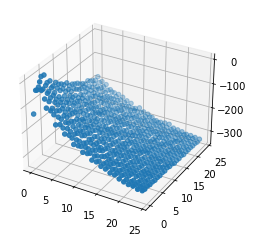

-6.229776399999946
[0 3]


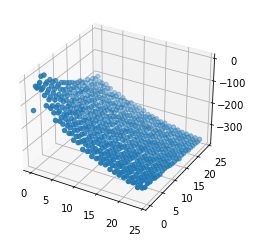

-7.9772709999999165
[1 1]


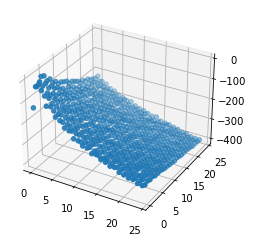

-10.489040099999873
[1 1]


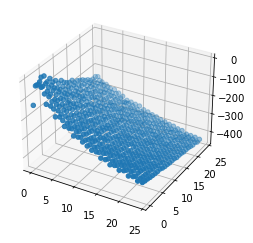

-13.153467799999802
[1 1]


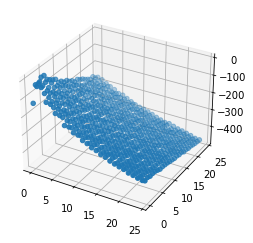

In [83]:
import matplotlib.pyplot as plt
from matplotlib import cm

for ix in range(5):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.array(simulations)[625*ix:625*(ix+1),0]
    Y = np.array(simulations)[625*ix:625*(ix+1),1]
    Z = np.array(utilities)[625*ix:625*(ix+1)]
    print(Z[np.argmax(Z)])
    print(np.array(simulations)[625*ix:625*(ix+1),:][np.argmax(Z)])
    ax.scatter(X, Y, Z)
    plt.show()

In [42]:
print(np.argmax(utilities))
utilities

53


[array([-127., -127.]),
 array([-31.45, -31.45]),
 array([-30.2, -30.2]),
 array([-12.35, -12.35]),
 array([-12.75, -12.75]),
 array([-41.45, -41.45]),
 array([-41.3, -41.3]),
 array([-67.65, -67.65]),
 array([-66.4, -66.4]),
 array([-87.1, -87.1]),
 array([-89.2, -89.2]),
 array([-102.9, -102.9]),
 array([-105.8, -105.8]),
 array([-132.3, -132.3]),
 array([-124.35, -124.35]),
 array([-135.15, -135.15]),
 array([-144.05, -144.05]),
 array([-154.15, -154.15]),
 array([-154.1, -154.1]),
 array([-157.45, -157.45]),
 array([-168.15, -168.15]),
 array([-178.6, -178.6]),
 array([-182.3, -182.3]),
 array([-190.1, -190.1]),
 array([-188.6, -188.6]),
 array([-28.55, -28.55]),
 array([-4.65, -4.65]),
 array([-31.1, -31.1]),
 array([-29.25, -29.25]),
 array([-57.9, -57.9]),
 array([-49.6, -49.6]),
 array([-81.15, -81.15]),
 array([-77.9, -77.9]),
 array([-92.25, -92.25]),
 array([-101.2, -101.2]),
 array([-119.9, -119.9]),
 array([-115.15, -115.15]),
 array([-131.8, -131.8]),
 array([-135.05, -13

In [40]:
print(simulations[np.argmax(utilities)])
simulations

(2, 3)


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 22),
 (2, 23),
 (2, 24),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (3, 20),
 (3, 21),
 (3, 22),
 (3, 23),
 (3, 24),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4,